In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.distributions import MultivariateNormal as MNormal
from torch.distributions import Normal, Categorical
from matplotlib import pyplot as plt

from ex2mcmc.samplers import mala, i_sir, ex2_mcmc, flex2_mcmc, RealNVPProposal, flex2_mcmc_wcoefs
import tqdm

In [5]:
ceph_home = '/Users/marylou/Dropbox/Prof/Experiments/_ceph/mixed-kernel/rebut-neurips/3-gaussians'

### Put parameters of the target density

In [6]:
#method to compute log probability
def log_prob(x: torch.FloatTensor, detach = False) -> torch.FloatTensor:
        """
        Returns:
            log p(x)
        """
        log_ps = torch.stack([
            torch.log(weight) + gauss.log_prob(x) for weight, gauss in zip(weights, gaussians)
            ], dim=0)
        return torch.logsumexp(log_ps, dim=0)

In [7]:
#initialize starting points for the distribution
seed = 42
torch.manual_seed(42)
device = 'cpu'

#initialize dimension
dim = 50
#init scaling parameter for the density
a = 4.0
#standard deviations for the cluster centers
sigma = 1.0

#initialize centers of the clusters
center_pts = (np.random.rand(3,dim)-0.5)

locs = 4*torch.FloatTensor([center_pts[0,0:(dim-2)].tolist() + [0.0,1.0], \
                          center_pts[1,0:(dim-2)].tolist() + [np.sqrt(3)/2,-0.5], \
                          center_pts[2,0:(dim-2)].tolist()+ [-np.sqrt(3)/2,-0.5]])
covs = sigma*torch.eye(dim)[None, ...].repeat(3, 1, 1).float()
#normalized weights of the mixture
weights = torch.FloatTensor([1, 1, 1])
weights /= weights.sum()
#create Gaussian densities with different centers
gaussians = [MNormal(loc, cov) for loc, cov in zip(locs, covs)]


#init number of trajectories
N_traj = 100
#init starting points 
x0 = torch.randn(N_traj, dim).to(device)

In [8]:
center_pts[1]

array([ 0.24541532, -0.37529477, -0.42476135, -0.47995367, -0.13290084,
        0.47322765,  0.10353897,  0.27776709, -0.42911086, -0.30845265,
       -0.34981437, -0.34615114,  0.49575297,  0.47074933, -0.11006603,
       -0.46363056, -0.35322003, -0.15397784,  0.14128879,  0.17839372,
       -0.44881194,  0.49293243,  0.24581603, -0.43749091,  0.46129539,
       -0.2538197 ,  0.45875225, -0.18135717,  0.15895703,  0.22077257,
        0.2931685 , -0.02992173,  0.3025307 ,  0.17922147,  0.17509872,
        0.0263372 , -0.48063783, -0.1216785 , -0.09104043, -0.07576997,
       -0.18403092,  0.37280739, -0.05822078,  0.0115925 ,  0.43963277,
       -0.43148732,  0.42742918,  0.06504695,  0.3645018 , -0.15528664])

### Plot density contours

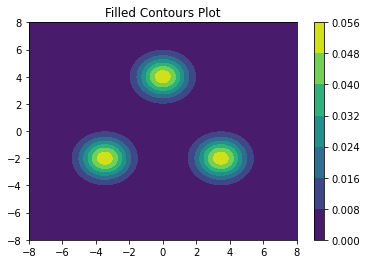

In [9]:
def plot_density_countours():
    N_pts = 100
    x = np.linspace(-2*a, 2*a, 100)
    y = np.linspace(-2*a, 2*a, 100)
    X, Y = np.meshgrid(x, y)
    #stack the two
    inp = torch.FloatTensor(np.stack([X, Y], -1))
    proj_slice = [-2, -1]

    #project onto the last 2 coordinates
    loc_gaussians = [MNormal(loc[proj_slice], cov[proj_slice, :][:, proj_slice]) for loc, cov in zip(locs, covs)]
    log_ps = torch.stack([
        torch.log(weight) + gauss.log_prob(inp.reshape(-1, 2)) for weight, gauss in zip(weights, loc_gaussians)
    ], dim=0)
    dens_vals = torch.logsumexp(log_ps, dim=0).reshape(inp.shape[:-1])
    #plot density values
    fig,ax=plt.subplots(1,1)
    cp = ax.contourf(X, Y, dens_vals.exp())
    fig.colorbar(cp) # Add a colorbar to a plot
    ax.set_title('Filled Contours Plot')
    return fig, ax

fig, ax = plot_density_countours()



### Sample with i-SIR algorithm

In [41]:
N_steps = 1000
N_part = 200
sigma_isir = 2.0

#choose proposal for i-SIR algorithm
isir_proposal = MNormal(
    torch.zeros(dim).to(device), (sigma_isir ** 2) * torch.eye(dim).to(device)
)

#run i-SIR
Samples_isir = i_sir(log_prob, x0, N_steps, N_part, isir_proposal, seed=42)

100%|██████████| 1000/1000 [01:38<00:00, 10.18it/s]


In [42]:
torch.save(Samples_isir, f'{ceph_home}/Samples_isir_sigmaisir{sigma_isir}_Npart{N_part}.pt')

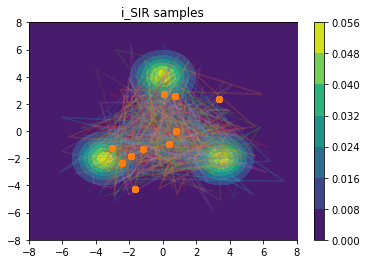

In [51]:
fig, ax = plot_density_countours()
ax.set_title('i_SIR samples')

for i in range(100):
    ax.plot(Samples_isir[i,:,-2],Samples_isir[i,:,-1], alpha=0.2)
    if i == 1:
        ax.scatter(Samples_isir[i,:,-2],Samples_isir[i,:,-1], zorder=10, c='C1')

### Sample the same mixture with MALA

In [8]:
#MALA steps
N_steps = 1000
gamma = 0.5
N_steps_mala = 3

stats = None

#sample with MALA
Samples_mala = mala(log_prob, x0, N_steps, gamma, N_steps_mala, stats=None, seed=42)
Samples_mala.shape

100%|██████████| 1000/1000 [02:13<00:00,  7.52it/s]


torch.Size([100, 1001, 50])

In [32]:
torch.save(Samples_mala, f'{ceph_home}/Samples_mala_gamma{gamma}_Nstepsmala{N_steps_mala}.pt')

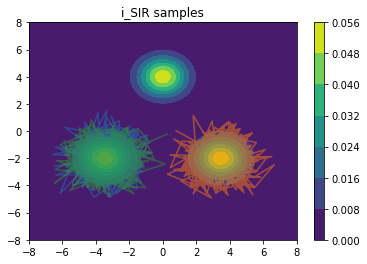

In [35]:
fig, ax = plot_density_countours()
ax.set_title('i_SIR samples')

for i in range(3):
    ax.plot(Samples_mala[i,:,-2],Samples_mala[i,:,-1], alpha=0.5)

### Sample the same mixture with Ex$^2$MCMC

In [69]:
N_steps = 1000
N_part = 200
sigma_isir = 3.0

#choose proposal for i-SIR algorithm
isir_proposal = MNormal(
    torch.zeros(dim).to(device), (sigma_isir ** 2) * torch.eye(dim).to(device)
)

Samples_ex2 = ex2_mcmc(log_prob, x0, N_steps, N_part, isir_proposal, gamma, N_steps_mala, stats=None, seed=42)
Samples_ex2.shape

100%|██████████| 1000/1000 [03:19<00:00,  5.01it/s]


torch.Size([100, 1001, 50])

In [72]:
torch.save(Samples_ex2, f'{ceph_home}/Samples_ex2_sigmaisir{sigma_isir}_Npart{N_part}_Nstepsmala{N_steps_mala}.pt')

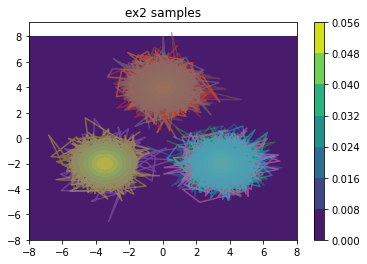

In [73]:
fig, ax = plot_density_countours()
ax.set_title('ex2 samples')

for i in range(10):
    ax.plot(Samples_ex2[i,:,-2],Samples_ex2[i,:,-1], alpha=0.5)

### Sample the same mixture with Flex$^2$MCMC

In [55]:
seed = 42
torch.manual_seed(seed)

N_samples=100

scale_chains_init = 1.
x0 = scale_chains_init * torch.randn(N_samples, dim).to(device)

n_hidden = 100
prior_scale = 1
isir_proposal = RealNVPProposal(lat_size=dim, device=device, hidden=n_hidden, prior_scale=prior_scale).to(device)
proposal_opt = torch.optim.Adam(isir_proposal.parameters(), lr=1e-3)

with_pretraining = True
## training using random samples - 
if with_pretraining:
    for _ in tqdm.tqdm(range(100)):
        proposal_opt.zero_grad()
        loss = -isir_proposal.log_prob(10 * torch.randn(1000, dim).to(device)).mean()
        loss.backward()
        proposal_opt.step()
    
N_steps = 1000
N_particles = 3

gamma = 0.5
mala_iters = 3

stats = {'n_accepts': 0}

coef_kl_back = 1.0
coef_kl_forw = 0.0
coef_entropy = 0.1
#generate flex2 samples
Samples_flex2, losses, isir_proposal = flex2_mcmc_wcoefs(log_target_dens=log_prob, x0=x0, 
                                  N_steps=N_steps, N_part=N_particles, isir_proposal=isir_proposal, gamma=gamma, mala_iters=mala_iters, stats=stats, 
                                  coef_kl_back=coef_kl_back, coef_kl_forw=coef_kl_forw,
                                  coef_entropy=coef_entropy)

Samples_flex2.shape
plt.plot(losses)

 87%|████████▋ | 867/1000 [11:54<02:09,  1.02it/s]

In [ ]:
saved_at =  f'{ceph_home}/Samples_flex2_Npart{N_particles}_Nstepsmala{mala_iters}_coefback{coef_kl_back}_forw{coef_kl_forw}_rnvphidden{n_hidden}_scalechainsinit{scale_chains_init}_priorscale{prior_scale}_coefentropy{coef_entropy}' 
if with_pretraining == True:
    saved_at += '_withpretraining'
saved_at += '.pt' 

torch.save(Samples_flex2, saved_at)

print(saved_at)



/Users/marylou/Dropbox/Prof/Experiments/_ceph/mixed-kernel/rebut-neurips/3-gaussians/Samples_flex2_Npart3_Nstepsmala3_coefback1.0_forw0.0_rnvphidden100_scalechainsinit1.0_priorscale10_coefentropy0.1.pt


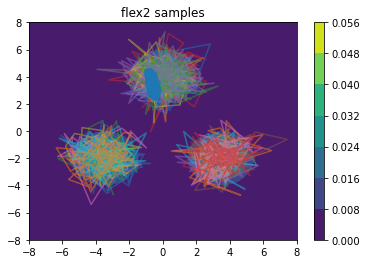

In [53]:
fig, ax = plot_density_countours()
ax.set_title('flex2 samples')

for i in range(25):
    ax.plot(Samples_flex2[i,-100:,-2],Samples_flex2[i,-100:,-1], alpha=0.5)
    # ax.scatter(Samples_flex2[i,-100:,-2],Samples_flex2[i,-100:,-1], alpha=0.5)
samples = isir_proposal.sample(1000).detach().cpu().numpy()
plt.scatter(samples[:,-2], samples[:,-1], alpha=0.5,zorder=10)

In [ ]:
seed = 42
torch.manual_seed(seed)

N_samples=100

x0 = torch.randn(N_samples, dim).to(device)

isir_proposal = RealNVPProposal(lat_size=dim,device=device).to(device)
proposal_opt = torch.optim.Adam(isir_proposal.parameters(), lr=1e-3)

## training using random samples - 

# for _ in tqdm.tqdm(range(100)):
#     proposal_opt.zero_grad()
#     loss = -isir_proposal.log_prob(10 * torch.randn(1000, dim).to(device)).mean()
#     loss.backward()
#     proposal_opt.step()
    
N_steps = 1000
sigma_isir = 4.0
N_particles = 3

gamma = 0.5
mala_iters = 3

stats = {'n_accepts': 0}

#generate flex2 samples
Samples_flex2, losses = flex2_mcmc_wcoefs(log_target_dens=log_prob, x0=x0, 
                                  N_steps=N_steps, N_part=N_particles, isir_proposal=isir_proposal, gamma=gamma, mala_iters=mala_iters, stats=stats, 
                                  coef_kl_back=1.0, coef_kl_forw=0)

Samples_flex2.shape
plt.plot(losses)

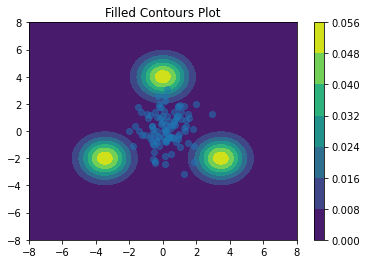

In [86]:
samples = isir_proposal.sample(100).detach().cpu().numpy()
fig, ax = plot_density_countours()
plt.scatter(samples[:,0], samples[:,1], alpha=0.5)

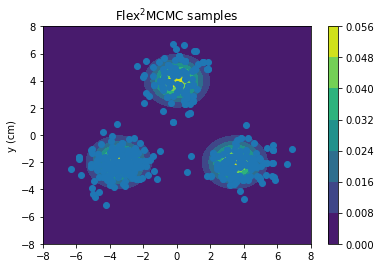

In [12]:
N_pts = 100
part_n = 2
x = np.linspace(-2*a, 2*a, N_pts)
y = np.linspace(-2*a, 2*a, N_pts)
X, Y = np.meshgrid(x, y)
#stack the two
inp = torch.FloatTensor(np.stack([X, Y], -1))
proj_slice = [-2, -1]

#project onto the last 2 coordinates
loc_gaussians = [MNormal(loc[proj_slice], cov[proj_slice, :][:, proj_slice]) for loc, cov in zip(locs, covs)]
log_ps = torch.stack([
    torch.log(weight) + gauss.log_prob(inp.reshape(-1, 2)) for weight, gauss in zip(weights, loc_gaussians)
], dim=0)
dens_vals = torch.logsumexp(log_ps, dim=0).reshape(inp.shape[:-1])
#plot density values
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, dens_vals.exp())
fig.colorbar(cp) # Add a colorbar to a plot
#plot mala samples
ax.scatter(Samples_flex2[part_n,-500:,-2],Samples_flex2[part_n,-500:,-1])
ax.set_title('Flex$^2$MCMC samples')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()

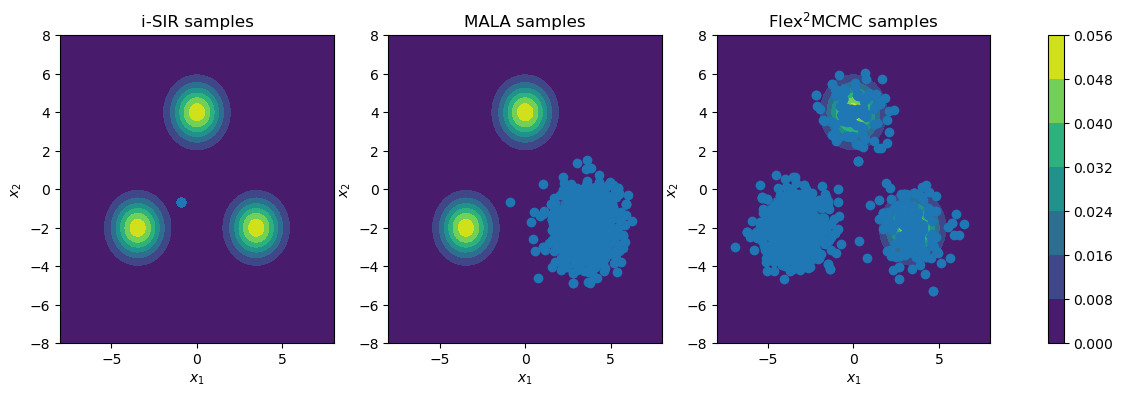

In [53]:
fig,ax = plt.subplots(1,3,figsize=(15,4))
#select the index of the visualized trajectory
traj_ind = 0
im = ax[0].contourf(X, Y, dens_vals.exp())
im = ax[1].contourf(X, Y, dens_vals.exp())
im = ax[2].contourf(X, Y, dens_vals.exp())
fig.colorbar(im, ax=ax.flat) # Add a colorbar to a plot
#i-sir plots
ax[0].scatter(Samples_isir[traj_ind,:,-2],Samples_isir[traj_ind,:,-1])
ax[0].set_title('i-SIR samples')
ax[0].set_xlabel('$x_1$')
ax[0].set_ylabel('$x_2$')
#mala samples
ax[1].scatter(Samples_mala[traj_ind,:,-2],Samples_mala[traj_ind,:,-1])
ax[1].set_title('MALA samples')
ax[1].set_xlabel('$x_1$')
ax[1].set_ylabel('$x_2$')
#flex2-mcmc sample
ax[2].scatter(Samples_flex2[traj_ind,:,-2],Samples_flex2[traj_ind,:,-1])
ax[2].set_title('Flex$^2$MCMC samples')
ax[2].set_xlabel('$x_1$')
ax[2].set_ylabel('$x_2$')
plt.savefig("toy_samples_flex_50d_the_guy_not_to_worry_about.pdf", format="pdf", bbox_inches="tight") 
plt.show()

In [ ]:
import torch

fig, axes = plt.subplots(1,3,figsize=(15,4))
N_pts = 100
xlist = np.linspace(-2*a, 2*a, 100)
ylist = np.linspace(-2*a, 2*a, 100)
X, Y = np.meshgrid(xlist, ylist)
points = np.zeros((2,X.shape[0],X.shape[1]),dtype=float)
points[0] = X
points[1] = Y
dens_vals = np.zeros_like(X)
prop_vals = np.zeros_like(X)
for i in range(N_pts):
    for j in range(N_pts):
        dens_vals[i,j] = target_dens(points[:,i,j])
        prop_vals[i,j] = log_dens_isir(points[:,i,j], sigma_isir)

for na, ax in enumerate(axes):
    plt.sca(ax)
    plt.contourf(X, Y, dens_vals, 10, cmap='GnBu')
    plt.axis('off')
    if na > 0:
        plt.contour(X, Y, prop_vals, 10, colors='k', linestyles=':', alpha=0.25)
## to do equal ratio

# plt.title(title)
    
# plt.colorbar()
# plt.plot(xs[:, 0, 0], xs[:, 0, 1], 'o', c='r', alpha=0.25, ms=2.5)
chainss = [Samples_mala, Samples_isir, Samples_ex2]
titles = ['MALA samples', 'i-SIR samples', 'Ex$^2$MCMC samples']
for ax, chains, title in zip(axes, chainss, titles):
    plt.sca(ax)
    plt.title(title)
    xs = torch.tensor(chains, dtype=torch.float)
    posx, invx, countsx = torch.unique_consecutive(xs[:, 0], return_counts=True, return_inverse=True)

    posy, invy, countsy = torch.unique_consecutive(xs[:, 1], return_counts=True, return_inverse=True)

    plt.plot(xs[:, 0], xs[:, 1], '-', c='k', alpha=0.25)
    plt.scatter(posx, posy, marker='o', c='r', alpha=0.5, s=countsx*20)
    plt.scatter(xs[0,0], xs[0,1],  marker='*', c='k', alpha=0.75, s=40)
#plt.show()
plt.savefig('toy_samples_2d_gaus.pdf', format="pdf", bbox_inches="tight")
plt.show()